# Local linear network

In [115]:
import numpy as np
import sklearn
from nmf_with_missing_values import nmf_with_missing_values
import ipyvolume
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import scipy as sp
%matplotlib inline

## load the data

In [3]:
tmp = np.load('../data/mouse_brain_ISH_float32.npz')
data = tmp['data']
sections = tmp['sections'].item()
original_shape = data.shape
d = data.shape[1] * data.shape[2] * data.shape[3]
data = np.reshape(data, (data.shape[0], d))

## load the intermediate result 

In [4]:
f = np.load('../code/reza/nmf_result_ncomp_18.npz')
A = f['A']
original_shape = f['original_shape']
X_guess = f['X_guess']
coefs = f['D']

### reshape the dictionary

In [5]:
D_cube = A.reshape([18] + list(original_shape[1:])) 

In [6]:
assert np.allclose(D_cube[0,:], A[0, :].reshape(original_shape[1:]))

### compute the local linear network

In [7]:
def filter_genes(coefs, pps, threshold = .99):
    large_coefs = np.max(coefs[:, pps], 1) 
    return large_coefs > np.quantile(large_coefs, threshold)

In [41]:
def weighted_correlation(A, weights, demean=True):
    '''
    Compute the weighted correlation between columns of A using the weights.
    '''
    if demean:
        A = A - np.mean(A, 0, keepdims=True)
    mean_A = np.sum(A * weights, 1, keepdims=True) / np.sum(weights)
    print(mean_A.shape)
    cov = (A - mean_A) @ (A - mean_A).T
    corr = np.diag(np.diag(cov) ** -.5) @ cov @ np.diag(np.diag(cov)**-.5)
    return corr

### Step 0: combine duplicated genes

In [119]:
unique_gene_names = np.unique(list(sections.values()))

unique_X = np.zeros((len(unique_gene_names), X_guess.shape[1]))

for ind, name in enumerate(unique_gene_names):
    gene_ids = np.where([x == name for x in sections.values()])[0]
    #print(gene_ids)
    unique_X[ind,:] = np.mean(X_guess[gene_ids,:], 0)

In [121]:
# solve the coefs, this code takes some time
unique_coefs = np.zeros((unique_X.shape[0], coefs.shape[1]))
for row_ind in range(unique_X.shape[0]):
    new_coef,_ = sp.optimize.nnls(A.T, unique_X[row_ind,:])
    unique_coefs[row_ind, :] = new_coef

### Step 1: select genes that are high coefficients for at least one of the PPs

In [140]:
## pps = [16, 14, 6]
#pps = [5, 13, 12]
#pps = [4,8,9]
#pps = [0, 6, 8, 9, 12, 14, 15]
pps = [11]
weights = np.mean(A[pps], 0)
selected_gene_ids = filter_genes(unique_coefs, pps)
correlations = weighted_correlation(unique_X[selected_gene_ids,:], weights)
#correlations = np.corrcoef(X_guess[selected_gene_ids,:] * weights ** .5) 
selected_gene_names = unique_gene_names[selected_gene_ids]

(41, 1)


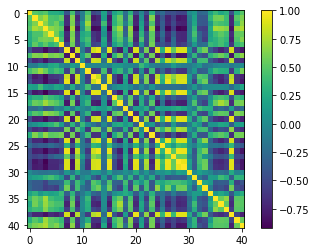

In [141]:
plt.imshow(correlations)
plt.colorbar()
plt.show()

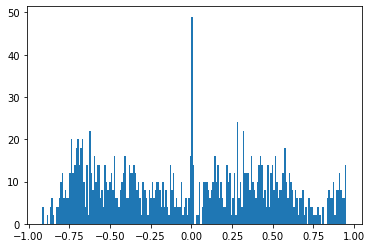

In [142]:
plt.hist((correlations - np.eye(correlations.shape[0])).flatten(),200)
plt.show()

In [143]:
import networkx as nx

In [144]:
#corr_matrix = np.corrcoef(selected_genes * weights ** .5) - np.eye(selected_genes.shape[0])
#lower_bound = np.percentile(correlations.flatten(), 5)
#adj_matrix = correlations < lower_bound
upper_bound = np.percentile(correlations.flatten(), 95)
adj_matrix = correlations > upper_bound
#adj_matrix = 0

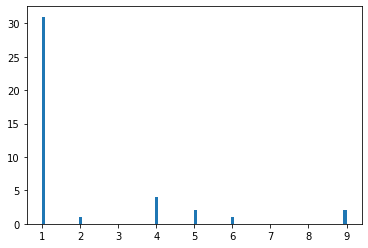

In [145]:
plt.hist(np.sum(adj_matrix, 0),100)
plt.show()

In [146]:
def show_graph_with_labels(adjacency_matrix, mylabels):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    
    remove = [node for node,degree in gr.degree() if degree <= 0.5]
    
    gr.remove_nodes_from(remove)
    nodes = set(ind for ind, name in gr.degree())
    pos = nx.spring_layout(gr,k=1.2,iterations=70)
    nx.draw(gr, pos, node_size=2000, labels={k:v for k, v in mylabels.items() if k in nodes}, with_labels=True)
    plt.show()
    print("There are {} connected components, plot each connected components that has more than one node".format(len(list(nx.connected_components(gr)))))
    # draw each connected components
    for c in sorted(nx.connected_components(gr), key=len, reverse=True):
        if len(c) == 1:
            continue
        plt.figure()
        nx.draw(gr.subgraph(c), pos, node_size=2000, labels={k:v for k, v in mylabels.items() if k in c}, with_labels=True)
        plt.show()

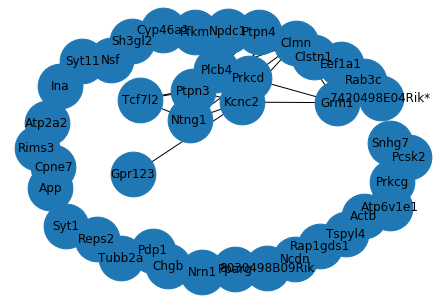

There are 32 connected components, plot each connected components that has more than one node


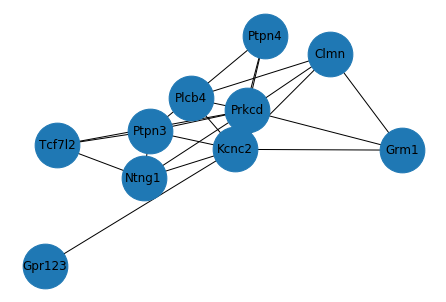

In [148]:
show_graph_with_labels(adj_matrix, {ind: name for ind, name in enumerate(selected_gene_names)})

- look at the genes in the cluster
- stability analysis
- correlation between atoms in the dictionary